# Skape-Gap Demo: application on boston sklearn dataset regression

    -----------------------------------------
    author: corentinV
    created: 30.11.2018
    last update: 03.12.2018

    warning: no tuning done yet
    to do: benchmark with time series model
        
    -----------------------------------------
    
This notebook shows a demo of skape-gap on the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html">boston</a> sklearn dataset.
    
skape-gap is appropriate for time series situation.
    
This notebook is structured in 5 parts:
    1. Imports
    2. Loading boston dataset
    3. Split train/test
    4. Modeling 
    5. Results
   
   
[Documentation] dataset boston of sklearn
        - https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names
        - https://www.scipy-lectures.org/packages/scikit-learn/auto_examples/plot_boston_prediction.html       
        

   
    

## 1. Imports

In [1]:
import datetime
import pandas as pd
import numpy as np

In [2]:
from sklearn import datasets 
from sklearn.metrics import mean_squared_error

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from skgap import SkapeGap

/home1/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 2. Loading dataset

In [5]:
# simulation de date pour les index d la table
dt = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2017, 12, 31)
step = datetime.timedelta(days=1)

result = []

while dt < end:
    result.append(dt.strftime('%Y-%m-%d'))
    dt += step

In [6]:
boston = datasets.load_boston()
df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']
df.index = result[:df.shape[0]]
df = df.iloc[:-30]
del boston

In [7]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
2016-01-01,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
2016-01-02,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2016-01-03,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
2016-01-04,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
2016-01-05,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 3. Split train/test

In [7]:
train = df.iloc[:-50]
date = train.index
X = train[df.columns[:-1]].values
y = train.target.values

test = df.iloc[-50:]
date_test = test.index
X_test =  test[df.columns[:-1]].values
y_test = test.target.values

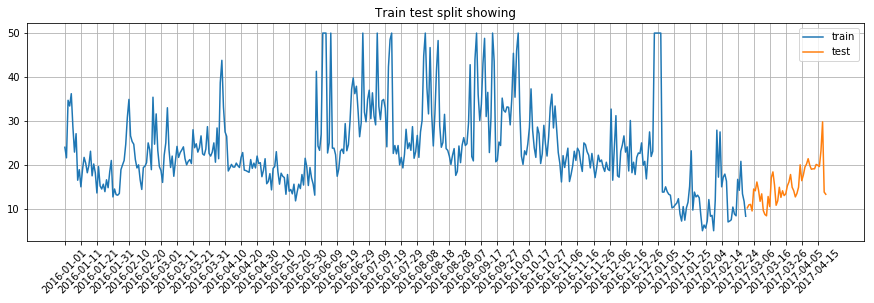

In [8]:
fig, ax =plt.subplots(figsize=(15,4))
ax.set_title('Train test split showing')
ax.plot(date, y)
ax.plot(date_test, y_test)
ax.set_xticks(np.arange(0,len(date)+len(date_test),10))
ax.set_xticklabels([(list(date) + list(date_test))[i] for i in  list(np.arange(0,len(date)+len(date_test),10))], rotation = 45)
plt.legend(['train', 'test'])
plt.grid(True)

## 4. Modeling 

In [9]:
model = SkapeGap(time_series='prophet', 
                 machine_learning='RF', 
                 put_zeros=False, 
                 
                yearly_seasonality = True,
                weekly_seasonality = False,
                daily_seasonality = False,
                seasonality_prior_scale = 0.03,
                 
                n_estimators_rf=5,
                criterion_rf='mse',
                max_depth_rf=5,
                min_samples_split_rf=4,
                min_samples_leaf_rf=4,
                max_features_rf='auto')

In [10]:
model.fit(date, X, y)

In [11]:
pred_train = model.predict(X)
pred_test = model.predict(X_test,50)

## 5. Results 

In [12]:
print('RMSE:')
err_train = mean_squared_error(y, pred_train)
print('Perf apprentissage: ', np.sqrt(err_train))
err_test = mean_squared_error(y_test, pred_test)
print('Perf test: ', np.sqrt(err_test))

RMSE:
Perf apprentissage:  3.664817094063631
Perf test:  3.9985605235146684


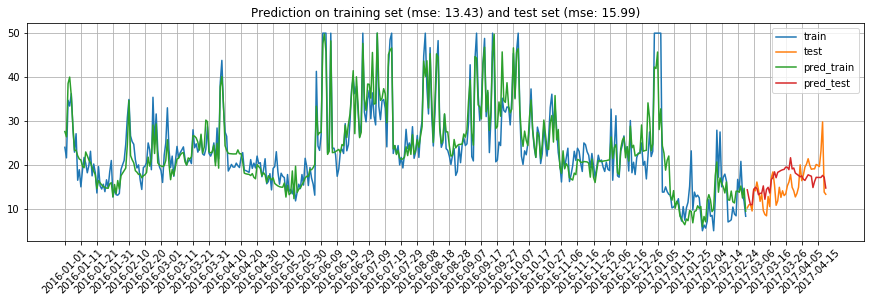

In [13]:
fig, ax =plt.subplots(figsize=(15,4))
ax.set_title('Prediction on training set (mse: ' 
                 + str(round(err_train,2)) 
                 +') and test set (mse: ' 
                 + str(round(err_test,2)) +')')
ax.plot(date, y)
ax.plot(date_test, y_test)
ax.plot(date, pred_train)
ax.plot(date_test, pred_test)
ax.set_xticks(np.arange(0,len(date)+len(date_test),10))
ax.set_xticklabels([(list(date) + list(date_test))[i] for i in  list(np.arange(0,len(date)+len(date_test),10))], rotation = 45)
plt.legend(['train', 'test', 'pred_train', 'pred_test'])
plt.grid(True)

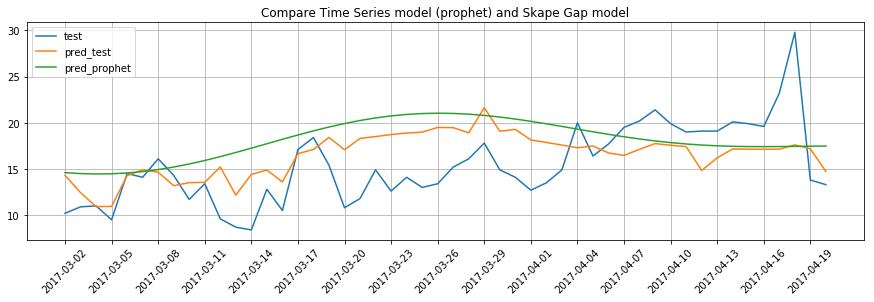

In [14]:
fig, ax =plt.subplots(figsize=(15,4))
ax.set_title('Compare Time Series model (prophet) and Skape Gap model')
ax.plot(date_test, y_test)
ax.plot(date_test, pred_test)
ax.plot(date_test, model.predict_prophet(50).yhat[-50:])
ax.set_xticks(np.arange(0,len(date_test),3))
ax.set_xticklabels([(list(date_test))[i] for i in  list(np.arange(0,len(date_test),3))], rotation = 45)
plt.legend(['test', 'pred_test', 'pred_prophet'])
plt.grid(True)